# Hierarchy-aware model-based selection

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
# load utils
from src.perceptual_descriptor_selection import *
from src.make_dataset.split_data import *

## Load feature dataset, labels and hierarchy map

In [2]:
# Load the full features
X_raw = pd.read_parquet("../data/processed/features_2080.parquet")
X_raw.index = X_raw.index.astype(int)

# Load labels
labels = pd.read_parquet("../data/processed/core_dataset.parquet")
labels = labels.set_index("song_id")
labels.index = labels.index.astype(int)

# Align features and labels
common_ids = X_raw.index.intersection(labels.index)

X = X_raw.loc[common_ids] # apply the alignment
y_valence_mean = labels.loc[common_ids, "valence_mean"]
y_arousal_mean = labels.loc[common_ids, "arousal_mean"]
y_valence_std = labels.loc[common_ids, "valence_std"]
y_arousal_std = labels.loc[common_ids, "arousal_std"]

print(f"Aligned features: {X.shape}")
print(f"Songs: {len(common_ids)}")
print("Label stats:")
print(f"  Valence mean: {y_valence_mean.mean():.3f} ± {y_valence_mean.std():.3f}")
print(f"  Arousal mean: {y_arousal_mean.mean():.3f} ± {y_arousal_mean.std():.3f}")

Aligned features: (1802, 2080)
Songs: 1802
Label stats:
  Valence mean: 4.904 ± 1.174
  Arousal mean: 4.814 ± 1.282


In [3]:
# Load the hierarchy map
hierarchy_map_path = Path("../data/hierarchy_map.csv")

hierarchy_map_full = pd.read_csv(hierarchy_map_path)
print(f"Loaded hierarchy map with {len(hierarchy_map_full)} feature mappings")
print("Hierarchy map columns:", hierarchy_map_full.columns.tolist())
print("\nFirst few mappings:")
print(hierarchy_map_full.head())

Loaded hierarchy map with 260 feature mappings
Hierarchy map columns: ['feature', 'perceptual', 'musical']

First few mappings:
                      feature          perceptual   musical
0           F0final_sma_amean       melodiousness     pitch
1        F0final_sma_de_amean       melodiousness     pitch
2       F0final_sma_de_stddev     tonal_stability     pitch
3          F0final_sma_stddev     tonal_stability     pitch
4  audSpec_Rfilt_sma[0]_amean  rhythmic_stability  spectral


In [4]:
# Show hierarchy summary
print(f"\nHierarchy summary:")
perceptual_counts = hierarchy_map_full['perceptual'].value_counts()
print(f"Perceptual-level categories ({len(perceptual_counts)}):")
for category, count in perceptual_counts.items():
    print(f"  {category}: {count} base features")


Hierarchy summary:
Perceptual-level categories (7):
  articulation: 60 base features
  tonal_stability: 52 base features
  dissonance: 48 base features
  rhythmic_complexity: 34 base features
  unmapped: 32 base features
  rhythmic_stability: 18 base features
  melodiousness: 16 base features


## Intra feature selection analysis

In [5]:
# per-category relevance of each descriptor (median |Spearman| across bases)
def relevance_table(X, y, hierarchy_map_full):
    descs = sorted({c.rsplit('_',1)[-1] for c in X.columns if '_' in c})
    cats  = sorted(hierarchy_map_full['perceptual'].unique())
    rows = []
    for cat in cats:
        bases = hierarchy_map_full[hierarchy_map_full['perceptual']==cat]['feature'].tolist()
        for d in descs:
            cors = []
            for b in bases:
                col = f"{b}_{d}"
                if col in X.columns:
                    s = X[col]
                    m = s.notna() & y.notna()
                    if m.sum() >= 10:
                        cors.append(abs(s[m].corr(y[m], method='spearman')))
            rows.append((cat, d, np.median(cors) if cors else np.nan))
    return (pd.DataFrame(rows, columns=['cat','desc','med_abs_spearman'])
              .pivot(index='cat', columns='desc', values='med_abs_spearman'))

tbl = relevance_table(X, y_valence_mean, hierarchy_map_full)
print(tbl.rank(axis=1, ascending=False).astype(int))  # see how often q25 ranks #1

desc                 kurtosis  max  mean  min  q25  q75  skew  std
cat                                                               
articulation                5    6     4    2    1    3     7    8
dissonance                  7    6     5    3    1    2     8    4
melodiousness               7    8     4    2    1    5     6    3
rhythmic_complexity         7    5     4    2    1    3     8    6
rhythmic_stability          8    6     4    2    1    3     7    5
tonal_stability             8    5     4    2    1    3     7    6
unmapped                    7    5     4    1    2    6     8    3


q25 descriptor heavily dominates, as well as min in the second place, followed by q75. This indicates that these descriptors carry the most signifficant signal, since they are the most correlated with the target labels. Pottentially they might shadow granular signal from other statistical descriptors, which is the motivation a more thorough investigation.

In [6]:
# drop the unmapped features for a fully interpretable model
# keep only the 6 perceptual categories (no unmapped)
VALID_CATS = ['melodiousness','articulation','rhythmic_stability',
              'rhythmic_complexity','dissonance','tonal_stability']
hierarchy_map = hierarchy_map_full[hierarchy_map_full['perceptual'].isin(VALID_CATS)].copy()

# trim X to columns whose base is in the (filtered) hierarchy
mapped_bases = set(hierarchy_map['feature'])
X = X[[c for c in X.columns if c.rsplit('_', 1)[0] in mapped_bases]].copy()
assert 'unmapped' not in hierarchy_map
print("X shape after drop:", X.shape)
print("categories:", hierarchy_map['perceptual'].value_counts().to_dict())

X shape after drop: (1802, 1824)
categories: {'articulation': 60, 'tonal_stability': 52, 'dissonance': 48, 'rhythmic_complexity': 34, 'rhythmic_stability': 18, 'melodiousness': 16}


In [48]:
from importlib import reload
from src import perceptual_descriptor_selection
from src.make_dataset import split_data

reload(perceptual_descriptor_selection)
reload(split_data)

<module 'src.make_dataset.split_data' from '/home/georgios/PGMP/notebooks/../src/make_dataset/split_data.py'>

In [62]:
cv5_splits = load_kfold_splits()

### Part 1: Rankings cache per fold (joint V+A)

In [11]:
# Precompute joint rankings for each fold once
from src.perceptual_descriptor_selection import compute_descriptor_ranking_joint_shap

rankings_by_fold = {}

rankings_per_fold = {}
for fold_id, (tr, va) in enumerate(cv5_splits):
    rankings_per_fold[fold_id] = compute_descriptor_ranking_joint_shap(
        X, y_valence_mean, y_arousal_mean, hierarchy_map,
        train_index=X.index.intersection(tr),
        n_estimators=100, sample_n=400, random_state=42
    )

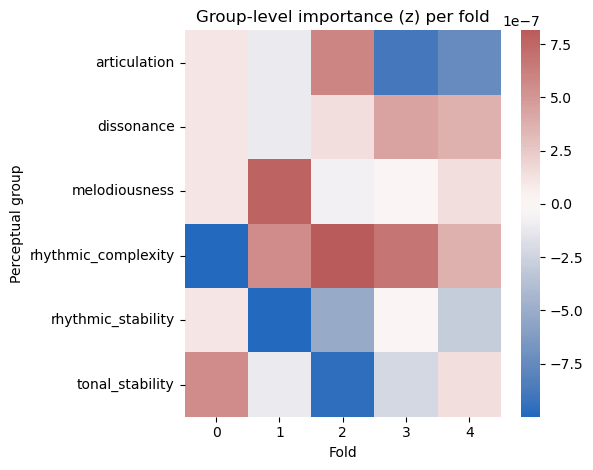

In [12]:
#visualize rankings per-fold to to check the stability of the feature selection process
plot_group_rank_stability(rankings_per_fold, hierarchy_map)

there is signifficant variability of the feature importances between groups...

### Part 2: Baseline vs per-base (same rankings, different aggregation)

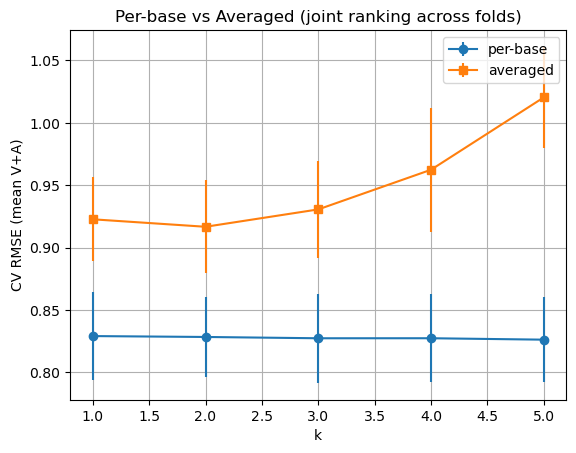

In [13]:
# k-sweep using rank-and-slice (per_base vs averaged)
from src.perceptual_descriptor_selection import cv_rmse_across_k_nested_joint_ranked, pick_best_k

df_joint_per_base = cv_rmse_across_k_nested_joint_ranked(
    X, y_valence_mean, y_arousal_mean, hierarchy_map,
    splits=cv5_splits, rankings_per_fold=rankings_per_fold,
    ks=range(1,6), aggregation_mode='per_base'
)

df_joint_avg = cv_rmse_across_k_nested_joint_ranked(
    X, y_valence_mean, y_arousal_mean, hierarchy_map,
    splits=cv5_splits, rankings_per_fold=rankings_per_fold,
    ks=range(1,6), aggregation_mode='perceptual'
)

plt.errorbar(df_joint_per_base.k, df_joint_per_base.rmse_mean, yerr=df_joint_per_base[["rmse_val_std","rmse_aro_std"]].mean(1), fmt='-o', label='per-base')
plt.errorbar(df_joint_avg.k,      df_joint_avg.rmse_mean,      yerr=df_joint_avg[["rmse_val_std","rmse_aro_std"]].mean(1),      fmt='-s', label='averaged')
plt.legend(); plt.grid(True); plt.xlabel("k"); plt.ylabel("CV RMSE (mean V+A)")
plt.title("Per-base vs Averaged (joint ranking across folds)"); plt.show()

In [14]:
# choose best k 
best_k = pick_best_k(df_joint_per_base)
print("Chosen k =", best_k)

Chosen k = 5


In [15]:
# confirm chosen k:
confirm = confirm_at_k_with_full_selection(
    X, y_valence_mean, y_arousal_mean, hierarchy_map,
    splits=cv5_splits, k=best_k, aggregation_mode='per_base',
    n_estimators=100, sample_n=800
)
print("Confirm @k:", confirm)
# If the confirm RMSE ≈ the ranked RMSE at k, the speedup is validated

Confirm @k: {'rmse_val_mean': 0.8193421232538975, 'rmse_val_std': 0.03628389559295975, 'rmse_aro_mean': 0.8347727158073519, 'rmse_aro_std': 0.03129971843873126, 'rmse_mean': 0.8270574195306247}


### Part 3: Weighting experiment 

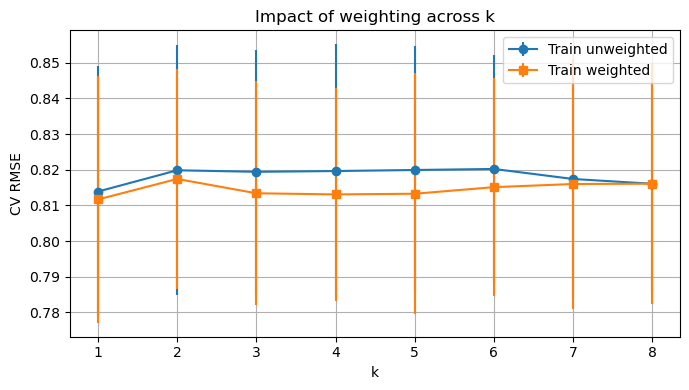

In [16]:
# Build per-base features with chosen k using union of all train ids for selection stability
# with effect-of-weighting curve - not using cached importance, selection adapts with weights
from src.perceptual_descriptor_selection import k_sweep_weighting_compare_nested

df_unweighted, df_weighted = k_sweep_weighting_compare_nested(
    X, y_valence_mean, hierarchy_map, cv5_splits, labels, std_col='valence_std',
    ks=range(1,9), use_marginal=True  # keeps leak-safe per-fold selection
)
plot_weighting_k_curves(df_unweighted, df_weighted)

weighting effect is minor - additionally, weights from annotator stds are not available in real-world scenarios, so proceed with unweighted losses on the models

### Part 4: Final model + SHAP with grouped summaries

In [17]:
#load custom split
tr, va, te = load_splits_triplet()
dev_ids = tr.union(va)

In [18]:
from src.perceptual_descriptor_selection import select_top_k_descriptors_joint_shap, build_per_base_X

sel_final = select_top_k_descriptors_joint_shap(
    X, y_valence_mean, y_arousal_mean, hierarchy_map, k=best_k,
    train_index=dev_ids, n_estimators=200, sample_n=800 #only pass the development ids
)
X_final = build_per_base_X(X, hierarchy_map, sel_final)
med = X_final.median(numeric_only=True)
X_final = X_final.fillna(med)

In [19]:
# Train final RF (unweighted, to mirror real-world scenarios where no annotator std is available)
final_model = RandomForestRegressor(n_estimators=400, max_features='sqrt',
                                    min_samples_leaf=2, random_state=42, n_jobs=-1)
final_model.fit(X_final, y_valence_mean.loc[X_final.index])

,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
# SHAP aggregated by perceptual to visualize the feature importance in the mid-level
sample_X = X_final.sample(min(800, len(X_final)), random_state=42)
explainer = shap.TreeExplainer(final_model)
sv = explainer.shap_values(sample_X)

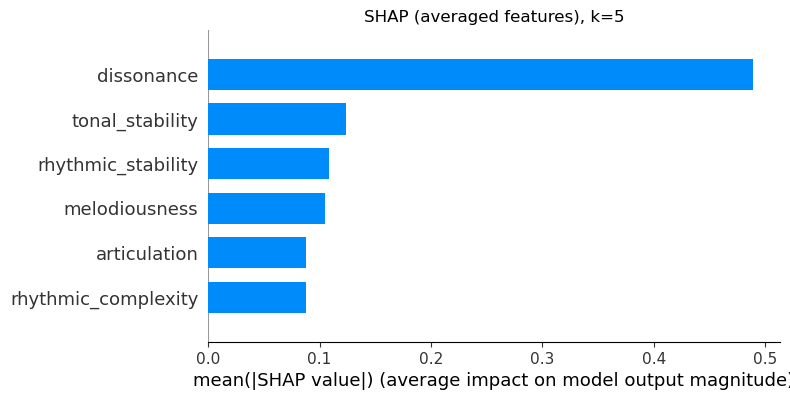

In [21]:
# averaged (baseline)
rf_avg, X_avg, mean_abs_avg, order_avg, exp_avg = shap_summary_for_k(
    X, y_valence_mean, hierarchy_map, k=best_k, mode='perceptual'
)
shap.summary_plot(exp_avg.shap_values(X_avg), X_avg, plot_type="bar", show=False)
plt.title(f"SHAP (averaged features), k={best_k}"); plt.show()

As shown above, the baseline model using simple averaging is heavily dominated by the 'dissonance' and 'rhythmic_complexity' feature. This masks the contribution of other important musical cues, motivating a more sophisticated feature engineering approach.

In [28]:
shap_grouped, X_grouped, group_names = aggregate_shap_for_summary(
    sv, sample_X, hierarchy_map, level='perceptual'
)

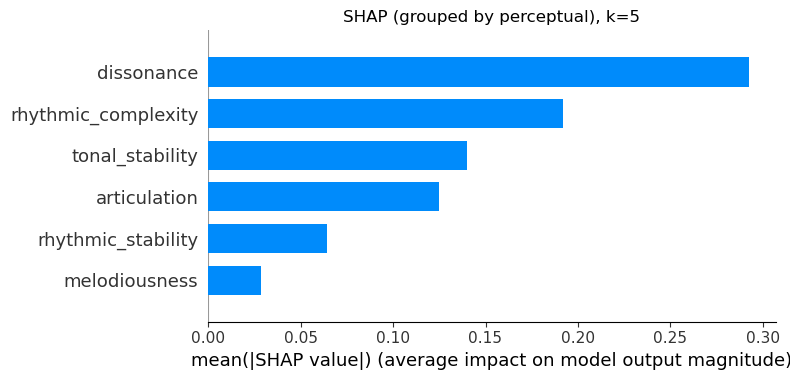

In [34]:
X_grouped_df = pd.DataFrame(X_grouped, index=sample_X.index, columns=group_names)
shap.summary_plot(shap_grouped,X_grouped_df,plot_type="bar",max_display=7, show=False)
plt.title(f"SHAP (grouped by perceptual), k={best_k}")
plt.tight_layout()
plt.show()

Features reserve more granularity when not aggregated as demonstrated by the feature importance plot (mean, across samples) which can enable the signal to become more balanced, and let each feature contribute in non linear ways.

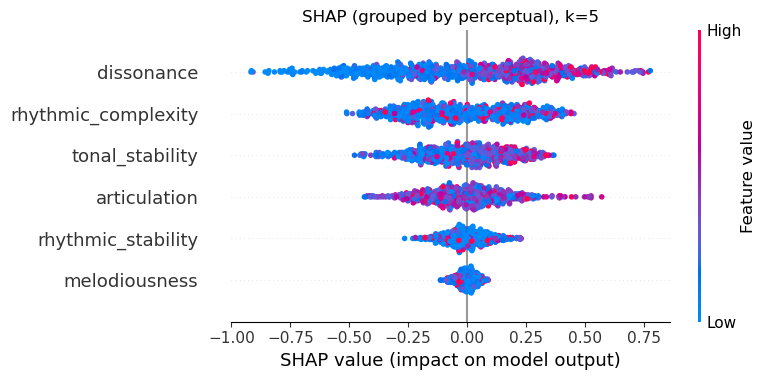

In [35]:
shap.summary_plot(shap_grouped, X_grouped, feature_names=group_names, show=False)
plt.title(f"SHAP (grouped by perceptual), k={best_k}"); plt.tight_layout(); plt.show()

This plot reveals how different feature values impact valence predictions:
- Red/blue dots show high/low feature values
- Position on x-axis shows impact on model output
- Features are ordered by overall importance
- The spread shows how consistently each feature contributes

### Save optimal configuration

In [41]:
import json

optimal_config = {
    'best_k': int(best_k),
    'method': 'RF',
    'aggregation': 'per_base',
    'weighted': False,
    'final_model': {'estimator': 'RandomForestRegressor', 'n_estimators': 400, 'random_state': 42},
    'selections': {k: list(map(str, v)) for k, v in sel_final.items()}
}

with open('../results/experiments/exp1_full_2080/optimal_descriptor_config.json', 'w') as f:
    json.dump(optimal_config, f, indent=2)

print(f"\nOptimal configuration saved to 'optimal_descriptor_config.json'")


Optimal configuration saved to 'optimal_descriptor_config.json'


# Visualise final category selections

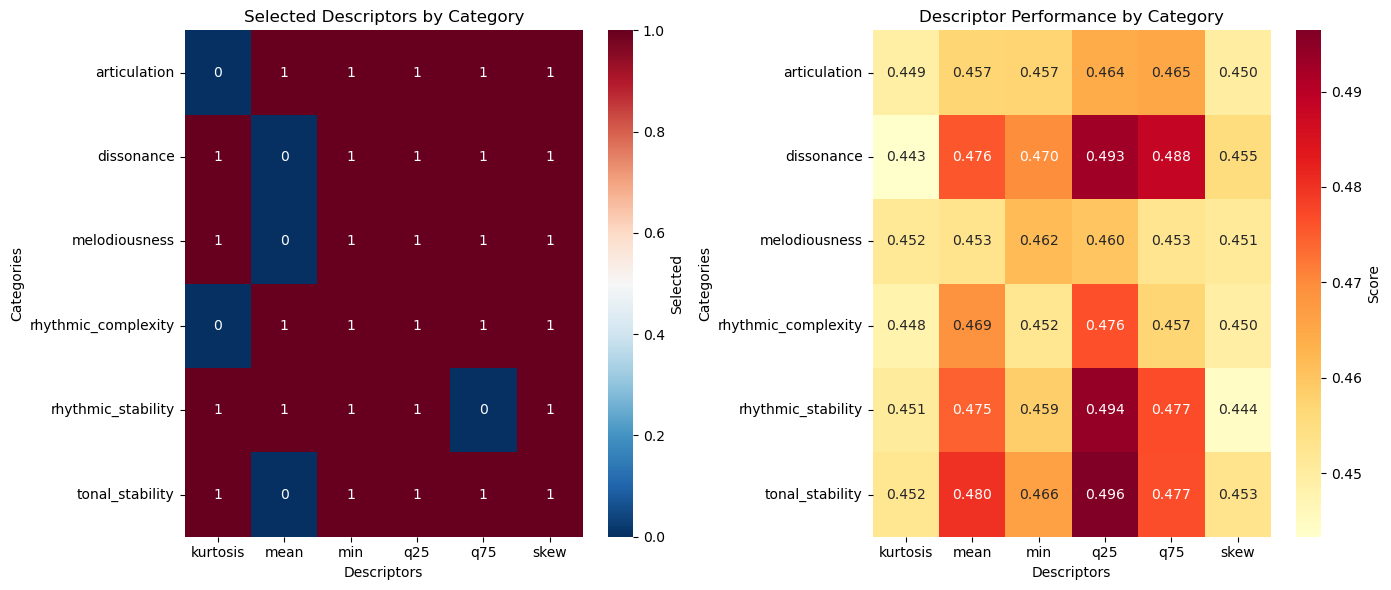

In [49]:
from src.perceptual_descriptor_selection import visualize_category_selections

# Show what descriptors were selected for each category
selection_matrix, performance_matrix = visualize_category_selections(
    sel_final, X, y_valence_mean, hierarchy_map
)

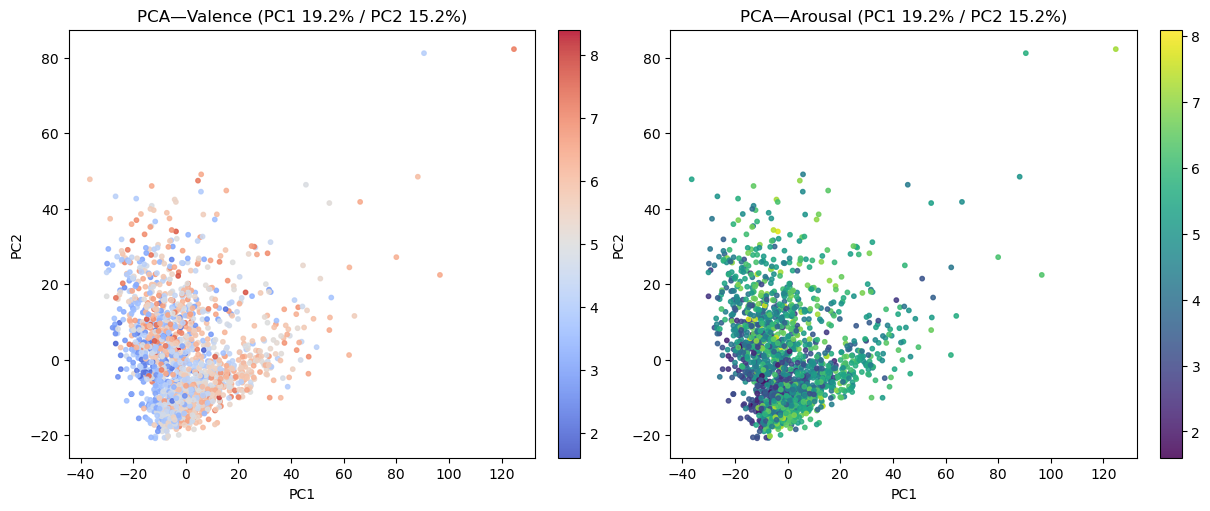

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

idx = X_final.index.intersection(y_valence_mean.index).intersection(y_arousal_mean.index)
Z = StandardScaler().fit_transform(X_final.loc[idx].fillna(X_final.loc[idx].median()))
p = PCA(n_components=2, random_state=42).fit(Z)
PC = p.transform(Z); v1,v2 = p.explained_variance_ratio_*100

va = y_valence_mean.loc[idx].astype(float).values
ar = y_arousal_mean.loc[idx].astype(float).values

fig, ax = plt.subplots(1,2,figsize=(12,5), constrained_layout=True)
s=ax[0].scatter(PC[:,0],PC[:,1],c=va,s=10,cmap='coolwarm',alpha=.85)
ax[0].set(title=f"PCA—Valence (PC1 {v1:.1f}% / PC2 {v2:.1f}%)",xlabel='PC1',ylabel='PC2'); fig.colorbar(s,ax=ax[0])
s=ax[1].scatter(PC[:,0],PC[:,1],c=ar,s=10,cmap='viridis',alpha=.85)
ax[1].set(title=f"PCA—Arousal (PC1 {v1:.1f}% / PC2 {v2:.1f}%)",xlabel='PC1',ylabel='PC2'); fig.colorbar(s,ax=ax[1])
plt.show()

In [51]:
# Fit PCA on the selected per-base features
Xf = X_final.fillna(X_final.median())
Z  = StandardScaler().fit_transform(Xf)
pca = PCA(n_components=2, random_state=42).fit(Z)

scores   = pd.DataFrame(pca.transform(Z), index=Xf.index, columns=['PC1','PC2'])
loadings = pd.DataFrame(pca.components_.T, index=Xf.columns, columns=['PC1','PC2'])
expl_var = pca.explained_variance_ratio_
print(f"Explained variance: PC1={expl_var[0]:.2%}, PC2={expl_var[1]:.2%}")

# How PCs relate to Valence/Arousal (Spearman = robust)
corrs = scores.assign(valence=y_valence_mean.loc[scores.index],
                      arousal=y_arousal_mean.loc[scores.index]) \
              .corr(method='spearman').loc[['PC1','PC2'], ['valence','arousal']]
print(corrs)

Explained variance: PC1=19.22%, PC2=15.21%
      valence   arousal
PC1  0.310463  0.209671
PC2  0.060755  0.127106


## Add minorness from mode metadata, Create the mid and high-level features

In [56]:
# Build minorness score (0..1), index by song_id
mode_df = pd.read_parquet("../data/processed/audio_metadata.parquet")
m = mode_df[['song_id','mode','key_confidence']].copy()
m['is_minor'] = (m['mode'].str.lower() == 'minor').astype(int)
m['minorness'] = (m['is_minor'] * m['key_confidence']).astype(float)
m = m.set_index('song_id').reindex(X_final.index)

In [57]:
from importlib import reload
from src import derived

reload(derived)

<module 'src.derived' from '/home/georgios/PGMP/notebooks/../src/derived.py'>

In [58]:
from src.derived import create_perceptual_features
# Create mid-level features from the selected per-base features
perceptual_level_df = create_perceptual_features(X_final, hierarchy_map)
# append minorness for analysis (does not affect training/selection)
perceptual_level_df = perceptual_level_df.join(m[['minorness']], how='left')
print(f"Perceptual-level features shape: {perceptual_level_df.shape}")
print(f"Perceptual-level features: {perceptual_level_df.columns.tolist()}")

Perceptual-level features shape: (1802, 7)
Perceptual-level features: ['articulation', 'dissonance', 'melodiousness', 'rhythmic_complexity', 'rhythmic_stability', 'tonal_stability', 'minorness']


In [59]:
perceptual_level_df.head(1)

,articulation,dissonance,melodiousness,rhythmic_complexity,rhythmic_stability,tonal_stability,minorness
song_id,,,,,,,
2,0.820874,7431.617293,30.593513,1.16233,30.601718,20.40126,0.259305


In [60]:
# Create high-level features
from src.derived import create_musical_features
musical_level_df = create_musical_features(X_final, hierarchy_map)
musical_level_df = musical_level_df.join(m[['minorness']], how='left')
print(f"Musical-level features shape: {musical_level_df.shape}")
print(f"Musical-level features: {musical_level_df.columns.tolist()}")

Musical-level features shape: (1802, 10)
Musical-level features: ['spectral', 'rhythm', 'voice_quality', 'timbre', 'brightness', 'harmony', 'pitch', 'voice', 'dynamics', 'minorness']


In [63]:
# test minorness signal
Xb = X_final.copy()

# per-base design + minorness version
Xm = Xb.join(m[['minorness']].rename(columns={'minorness':'meta_minorness'}), how='left')
med = Xm.loc[dev_ids].median(numeric_only=True); Xm = Xm.fillna(med)

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

rmse_base = []
rmse_minor = []
for tr, va in cv5_splits:
    tr = Xb.index.intersection(tr); va = Xb.index.intersection(va)
    # base
    rf.fit(Xb.loc[tr], y_valence_mean.loc[tr])
    p = rf.predict(Xb.loc[va])
    rmse_base.append(np.sqrt(((y_valence_mean.loc[va]-p)**2).mean()))
    # +minorness
    rf.fit(Xm.loc[tr], y_valence_mean.loc[tr])
    p = rf.predict(Xm.loc[va])
    rmse_minor.append(np.sqrt(((y_valence_mean.loc[va]-p)**2).mean()))

print(f"ΔRMSE (valence): {np.mean(rmse_base)-np.mean(rmse_minor):.4f} (positive = minorness helps)")

ΔRMSE (valence): 0.0001 (positive = minorness helps)


The available mode metadata is not useful at this current stage.

# Train/val/test split

In [64]:
train_ids_custom, val_ids_custom, test_ids_custom = load_splits_triplet()

In [65]:
train_ids, val_ids, test_ids = load_splits_triplet(out_dir="../data/splits", name = 'original')

# Normalize features

In [68]:
from src.normalization import SplitScaler

# Split the data
X_train_orig = X_final.loc[train_ids]
X_val_orig = X_final.loc[val_ids]
X_test_orig = X_final.loc[test_ids]

In [69]:
# Normalize
scaler = SplitScaler()
X_train_scaled_orig = scaler.fit_transform(X_train_orig)
X_val_scaled_orig = scaler.transform(X_val_orig)
X_test_scaled_orig = scaler.transform(X_test_orig)

print(f"Train: {X_train_scaled_orig.shape}")
print(f"Val: {X_val_scaled_orig.shape}")
print(f"Test: {X_test_scaled_orig.shape}")

Train: (1488, 1140)
Val: (256, 1140)
Test: (58, 1140)


In [71]:
X_train_custom = X_final.loc[train_ids_custom]
X_val_custom = X_final.loc[val_ids_custom]
X_test_custom = X_final.loc[test_ids_custom]
# Normalize
scaler = SplitScaler()
X_train_scaled_custom = scaler.fit_transform(X_train_custom)
X_val_scaled_custom = scaler.transform(X_val_custom)
X_test_scaled_custom = scaler.transform(X_test_custom)
print(f"Train: {X_train_scaled_custom.shape}")
print(f"Val: {X_val_scaled_custom.shape}")
print(f"Test: {X_test_scaled_custom.shape}")

Train: (1257, 1140)
Val: (276, 1140)
Test: (269, 1140)


Note: Normalization at this stage after having already used the unscaled features throughout is fine. The reason is because the methods that were used to find optimal k descriptors per each low-level feature were scale agnostic (rf), but future distance based methods (like KNN) will require a more scaled feature space

# Save everything

In [72]:
import joblib

output_dir = Path("../data/processed/derived/exp1_full_2080")
output_dir.mkdir(exist_ok=True)

# Save feature sets at different levels
X_final.to_parquet(output_dir / "low_level_selected.parquet")
perceptual_level_df.to_parquet(output_dir / "perceptual_level.parquet")
musical_level_df.to_parquet(output_dir / "musical_level.parquet")

In [73]:
output_dir_orig = Path(output_dir / "orig_split/")
output_dir_custom = Path(output_dir / "custom_split/")
output_dir_orig.mkdir(exist_ok=True)
output_dir_custom.mkdir(exist_ok=True)
# Save splits
X_train_scaled_orig.to_parquet(output_dir_orig / "X_train_scaled_orig.parquet")
X_val_scaled_orig.to_parquet(output_dir_orig / "X_val_scaled_orig.parquet")
X_test_scaled_orig.to_parquet(output_dir_orig / "X_test_scaled_orig.parquet")

X_train_scaled_custom.to_parquet(output_dir_custom / "X_train_scaled_custom.parquet")
X_val_scaled_custom.to_parquet(output_dir_custom / "X_val_scaled_custom.parquet")
X_test_scaled_custom.to_parquet(output_dir_custom / "X_test_scaled_custom.parquet")

# Save targets
y_valence_mean.loc[train_ids].to_csv(output_dir_orig / "y_valence_train_orig.csv")
y_valence_mean.loc[val_ids].to_csv(output_dir_orig / "y_valence_val_orig.csv")
y_valence_mean.loc[test_ids].to_csv(output_dir_orig / "y_valence_test_orig.csv")

y_arousal_mean.loc[train_ids].to_csv(output_dir_orig / "y_arousal_train_orig.csv")
y_arousal_mean.loc[val_ids].to_csv(output_dir_orig / "y_arousal_val_orig.csv")
y_arousal_mean.loc[test_ids].to_csv(output_dir_orig / "y_arousal_test_orig.csv")

# Save targets
y_valence_mean.loc[train_ids_custom].to_csv(output_dir_custom / "y_valence_train_custom.csv")
y_valence_mean.loc[val_ids_custom].to_csv(output_dir_custom / "y_valence_val_custom.csv")
y_valence_mean.loc[test_ids_custom].to_csv(output_dir_custom / "y_valence_test_custom.csv")

y_arousal_mean.loc[train_ids_custom].to_csv(output_dir_custom / "y_arousal_train_custom.csv")
y_arousal_mean.loc[val_ids_custom].to_csv(output_dir_custom / "y_arousal_val_custom.csv")
y_arousal_mean.loc[test_ids_custom].to_csv(output_dir_custom / "y_arousal_test_custom.csv")

# Save scaler and config
joblib.dump(scaler, output_dir / "scaler.pkl")

print(f"\nAll features saved to {output_dir}/")
print(f"  Low-level (selected): {X_final.shape}")
print(f"  Perceptual-level: {perceptual_level_df.shape}")
print(f"  Musical-level: {musical_level_df.shape}")


All features saved to ../data/processed/derived/exp1_full_2080/
  Low-level (selected): (1802, 1140)
  Perceptual-level: (1802, 7)
  Musical-level: (1802, 10)


In [74]:
X_train_scaled_orig.head(2)

,audSpec_Rfilt_sma[16]_amean_q25,audSpec_Rfilt_sma[16]_amean_q75,audSpec_Rfilt_sma[16]_amean_skew,audSpec_Rfilt_sma[16]_amean_mean,audSpec_Rfilt_sma[16]_amean_min,audSpec_Rfilt_sma[16]_stddev_q25,audSpec_Rfilt_sma[16]_stddev_q75,audSpec_Rfilt_sma[16]_stddev_skew,audSpec_Rfilt_sma[16]_stddev_mean,audSpec_Rfilt_sma[16]_stddev_min,...,voicingFinalUnclipped_sma_de_stddev_q25,voicingFinalUnclipped_sma_de_stddev_kurtosis,voicingFinalUnclipped_sma_de_stddev_skew,voicingFinalUnclipped_sma_de_stddev_min,voicingFinalUnclipped_sma_de_stddev_q75,voicingFinalUnclipped_sma_stddev_q25,voicingFinalUnclipped_sma_stddev_kurtosis,voicingFinalUnclipped_sma_stddev_skew,voicingFinalUnclipped_sma_stddev_min,voicingFinalUnclipped_sma_stddev_q75
song_id,,,,,,,,,,,,,,,,,,,,,
2,-0.730967,-0.646354,1.224471,-0.552394,0.367766,-0.690989,-0.673438,1.674167,-0.590355,-0.595743,...,-0.788697,-0.085107,0.052256,-0.873341,-0.785261,-0.591338,1.746327,1.911180,-1.038199,-0.711398
3,-0.180710,-0.423871,2.615543,0.350377,-0.026401,-0.273745,-0.341930,2.458344,0.469197,-1.351741,...,-0.814010,-0.084130,0.063431,-0.873341,-0.829856,-0.909834,0.524824,0.863041,-1.038199,-0.320324


# Model Test

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from pathlib import Path

output_dir_orig = Path("../data/processed/derived/exp1_full_2080/orig_split/")

#### Original Split

In [2]:
# load scaled feature data
X_train_scaled_orig = pd.read_parquet(output_dir_orig / "X_train_scaled_orig.parquet")
X_val_scaled_orig = pd.read_parquet(output_dir_orig / "X_val_scaled_orig.parquet")
X_test_scaled_orig = pd.read_parquet(output_dir_orig / "X_test_scaled_orig.parquet")

# Load target data
y_valence_train_orig = pd.read_csv(output_dir_orig / "y_valence_train_orig.csv", index_col=0)
y_valence_val_orig = pd.read_csv(output_dir_orig / "y_valence_val_orig.csv", index_col=0)
y_valence_test_orig = pd.read_csv(output_dir_orig / "y_valence_test_orig.csv", index_col=0)

y_arousal_train_orig = pd.read_csv(output_dir_orig / "y_arousal_train_orig.csv", index_col=0)
y_arousal_val_orig = pd.read_csv(output_dir_orig / "y_arousal_val_orig.csv", index_col=0)
y_arousal_test_orig = pd.read_csv(output_dir_orig / "y_arousal_test_orig.csv", index_col=0)

In [3]:
# align data for consistent samples
y_train_target_orig = y_valence_train_orig.squeeze().reindex(X_train_scaled_orig.index).dropna()
X_train_scaled_orig = X_train_scaled_orig.reindex(y_train_target_orig.index) # No dropna here

y_val_target_orig = y_valence_val_orig.squeeze().reindex(X_val_scaled_orig.index).dropna()
X_val_scaled_orig = X_val_scaled_orig.reindex(y_val_target_orig.index)

y_test_target_orig = y_valence_test_orig.squeeze().reindex(X_test_scaled_orig.index).dropna()
X_test_scaled_orig = X_test_scaled_orig.reindex(y_test_target_orig.index)

y_aro_train_orig = y_arousal_train_orig.squeeze().reindex(X_train_scaled_orig.index).dropna()
y_aro_val_orig = y_arousal_val_orig.squeeze().reindex(X_val_scaled_orig.index).dropna()
y_aro_test_orig = y_arousal_test_orig.squeeze().reindex(X_test_scaled_orig.index).dropna()

print("Data loaded and aligned. Shapes:")
print(f"X_train: {X_train_scaled_orig.shape}, y_valence_train: {y_train_target_orig.shape}")
print(f"X_val: {X_val_scaled_orig.shape}, y_valence_val: {y_val_target_orig.shape}")
print(f"X_test: {X_test_scaled_orig.shape}, y_valence_test: {y_test_target_orig.shape}")

Data loaded and aligned. Shapes:
X_train: (1488, 1140), y_valence_train: (1488,)
X_val: (256, 1140), y_valence_val: (256,)
X_test: (58, 1140), y_valence_test: (58,)


In [4]:
# train and evaluate the models
# Valence Model
model_valence_orig = RandomForestRegressor(n_estimators=400, max_features='sqrt',
                                           min_samples_leaf=2, random_state=42, n_jobs=-1)
model_valence_orig.fit(X_train_scaled_orig, y_train_target_orig)

,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [5]:
# Predictions
y_pred_val_orig = model_valence_orig.predict(X_val_scaled_orig)
y_pred_test_orig = model_valence_orig.predict(X_test_scaled_orig)

# Metrics
mse_val_orig = mean_squared_error(y_val_target_orig, y_pred_val_orig)
rmse_val_orig = np.sqrt(mse_val_orig)
r2_val_orig = r2_score(y_val_target_orig, y_pred_val_orig)

mse_test_orig = mean_squared_error(y_test_target_orig, y_pred_test_orig)
rmse_test_orig = np.sqrt(mse_test_orig)
r2_test_orig = r2_score(y_test_target_orig, y_pred_test_orig)

print("--- Original Split Performance ---")
print(f"\nValidation set performance (Valence):")
print(f"  RMSE: {rmse_val_orig:.4f}")
print(f"  R²:   {r2_val_orig:.4f}")

print(f"\nTest set performance (Valence):")
print(f"  RMSE: {rmse_test_orig:.4f}")
print(f"  R²:   {r2_test_orig:.4f}")

--- Original Split Performance ---

Validation set performance (Valence):
  RMSE: 0.8743
  R²:   0.4717

Test set performance (Valence):
  RMSE: 1.4553
  R²:   -0.5117


In [6]:
# Arousal Model
model_arousal_orig = RandomForestRegressor(n_estimators=400, max_features='sqrt',
                                           min_samples_leaf=2, random_state=42, n_jobs=-1)
model_arousal_orig.fit(X_train_scaled_orig, y_aro_train_orig)

,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
# Predictions
y_pred_aro_val_orig = model_arousal_orig.predict(X_val_scaled_orig)
y_pred_aro_test_orig = model_arousal_orig.predict(X_test_scaled_orig)

# Metrics
mse_aro_val_orig = mean_squared_error(y_aro_val_orig, y_pred_aro_val_orig)
rmse_aro_val_orig = np.sqrt(mse_aro_val_orig)
r2_aro_val_orig = r2_score(y_aro_val_orig, y_pred_aro_val_orig)

mse_aro_test_orig = mean_squared_error(y_aro_test_orig, y_pred_aro_test_orig)
rmse_aro_test_orig = np.sqrt(mse_aro_test_orig)
r2_aro_test_orig = r2_score(y_aro_test_orig, y_pred_aro_test_orig)

print(f"\nValidation set performance (Arousal):")
print(f"  RMSE: {rmse_aro_val_orig:.4f}")
print(f"  R²:   {r2_aro_val_orig:.4f}")

print(f"\nTest set performance (Arousal):")
print(f"  RMSE: {rmse_aro_test_orig:.4f}")
print(f"  R²:   {r2_aro_test_orig:.4f}")


Validation set performance (Arousal):
  RMSE: 0.8144
  R²:   0.5993

Test set performance (Arousal):
  RMSE: 1.0282
  R²:   0.0275


#### Custom Split

In [8]:
output_dir_custom = Path("../data/processed/derived/exp1_full_2080/custom_split/")

In [9]:
# Load scaled feature data for the custom split
X_train_scaled_custom = pd.read_parquet(output_dir_custom / "X_train_scaled_custom.parquet")
X_val_scaled_custom = pd.read_parquet(output_dir_custom / "X_val_scaled_custom.parquet")
X_test_scaled_custom = pd.read_parquet(output_dir_custom / "X_test_scaled_custom.parquet")

# Load target data for the custom split
y_valence_train_custom = pd.read_csv(output_dir_custom / "y_valence_train_custom.csv", index_col=0)
y_valence_val_custom = pd.read_csv(output_dir_custom / "y_valence_val_custom.csv", index_col=0)
y_valence_test_custom = pd.read_csv(output_dir_custom / "y_valence_test_custom.csv", index_col=0)

y_arousal_train_custom = pd.read_csv(output_dir_custom / "y_arousal_train_custom.csv", index_col=0)
y_arousal_val_custom = pd.read_csv(output_dir_custom / "y_arousal_val_custom.csv", index_col=0)
y_arousal_test_custom = pd.read_csv(output_dir_custom / "y_arousal_test_custom.csv", index_col=0)

In [10]:
# Align data for consistent samples
y_train_target_custom = y_valence_train_custom.squeeze().reindex(X_train_scaled_custom.index).dropna()
X_train_scaled_custom = X_train_scaled_custom.reindex(y_train_target_custom.index)

y_val_target_custom = y_valence_val_custom.squeeze().reindex(X_val_scaled_custom.index).dropna()
X_val_scaled_custom = X_val_scaled_custom.reindex(y_val_target_custom.index)

y_test_target_custom = y_valence_test_custom.squeeze().reindex(X_test_scaled_custom.index).dropna()
X_test_scaled_custom = X_test_scaled_custom.reindex(y_test_target_custom.index)

y_aro_train_custom = y_arousal_train_custom.squeeze().reindex(X_train_scaled_custom.index).dropna()
y_aro_val_custom = y_arousal_val_custom.squeeze().reindex(X_val_scaled_custom.index).dropna()
y_aro_test_custom = y_arousal_test_custom.squeeze().reindex(X_test_scaled_custom.index).dropna()

print("Custom Split Data loaded and aligned. Shapes:")
print(f"X_train: {X_train_scaled_custom.shape}, y_valence_train: {y_train_target_custom.shape}")
print(f"X_val: {X_val_scaled_custom.shape}, y_valence_val: {y_val_target_custom.shape}")
print(f"X_test: {X_test_scaled_custom.shape}, y_valence_test: {y_test_target_custom.shape}")

Custom Split Data loaded and aligned. Shapes:
X_train: (1257, 1140), y_valence_train: (1257,)
X_val: (276, 1140), y_valence_val: (276,)
X_test: (269, 1140), y_valence_test: (269,)


In [11]:
# Valence Model
model_valence_custom = RandomForestRegressor(n_estimators=400, max_features='sqrt',
                                           min_samples_leaf=2, random_state=42, n_jobs=-1)
model_valence_custom.fit(X_train_scaled_custom, y_train_target_custom)

,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [12]:
# Predictions
y_pred_val_custom = model_valence_custom.predict(X_val_scaled_custom)
y_pred_test_custom = model_valence_custom.predict(X_test_scaled_custom)

# Metrics
mse_val_custom = mean_squared_error(y_val_target_custom, y_pred_val_custom)
rmse_val_custom = np.sqrt(mse_val_custom)
r2_val_custom = r2_score(y_val_target_custom, y_pred_val_custom)

mse_test_custom = mean_squared_error(y_test_target_custom, y_pred_test_custom)
rmse_test_custom = np.sqrt(mse_test_custom)
r2_test_custom = r2_score(y_test_target_custom, y_pred_test_custom)

print("\n--- Custom Split Performance ---")
print(f"\nValidation set performance (Valence):")
print(f"  RMSE: {rmse_val_custom:.4f}")
print(f"  R²:   {r2_val_custom:.4f}")

print(f"\nTest set performance (Valence):")
print(f"  RMSE: {rmse_test_custom:.4f}")
print(f"  R²:   {r2_test_custom:.4f}")


--- Custom Split Performance ---

Validation set performance (Valence):
  RMSE: 0.8147
  R²:   0.5194

Test set performance (Valence):
  RMSE: 0.9590
  R²:   0.3293


In [13]:
# Arousal Model
model_arousal_custom = RandomForestRegressor(n_estimators=400, max_features='sqrt',
                                           min_samples_leaf=2, random_state=42, n_jobs=-1)
model_arousal_custom.fit(X_train_scaled_custom, y_aro_train_custom)

,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
# Predictions
y_pred_aro_val_custom = model_arousal_custom.predict(X_val_scaled_custom)
y_pred_aro_test_custom = model_arousal_custom.predict(X_test_scaled_custom)

# Metrics
mse_aro_val_custom = mean_squared_error(y_aro_val_custom, y_pred_aro_val_custom)
rmse_aro_val_custom = np.sqrt(mse_aro_val_custom)
r2_aro_val_custom = r2_score(y_aro_val_custom, y_pred_aro_val_custom)

mse_aro_test_custom = mean_squared_error(y_aro_test_custom, y_pred_aro_test_custom)
rmse_aro_test_custom = np.sqrt(mse_aro_test_custom)
r2_aro_test_custom = r2_score(y_aro_test_custom, y_pred_aro_test_custom)

print(f"\nValidation set performance (Arousal):")
print(f"  RMSE: {rmse_aro_val_custom:.4f}")
print(f"  R²:   {r2_aro_val_custom:.4f}")

print(f"\nTest set performance (Arousal):")
print(f"  RMSE: {rmse_aro_test_custom:.4f}")
print(f"  R²:   {r2_aro_test_custom:.4f}")


Validation set performance (Arousal):
  RMSE: 0.8265
  R²:   0.6126

Test set performance (Arousal):
  RMSE: 0.9240
  R²:   0.4988


In [15]:
from pathlib import Path
import sys
sys.path.append('..')
from src.minimal_utils import save_results

In [16]:
# Group the metrics for the original split
orig_split = {
    "Valence": {
        "Validation": {"RMSE": rmse_val_orig, "R2": r2_val_orig},
        "Test": {"RMSE": rmse_test_orig, "R2": r2_test_orig}
    },
    "Arousal": {
        "Validation": {"RMSE": rmse_aro_val_orig, "R2": r2_aro_val_orig},
        "Test": {"RMSE": rmse_aro_test_orig, "R2": r2_aro_test_orig}
    }
}

# Save the results for the original split
save_results(
    name="exp1/RF_Orig_Split",
    history={},
    test_metrics=orig_split,
    save_dir=Path("../results/ML/")
)

In [17]:
# Group the metrics for the custom split
custom_split = {
    "Valence": {
        "Validation": {"RMSE": rmse_val_custom, "R2": r2_val_custom},
        "Test": {"RMSE": rmse_test_custom, "R2": r2_test_custom}
    },
    "Arousal": {
        "Validation": {"RMSE": rmse_aro_val_custom, "R2": r2_aro_val_custom},
        "Test": {"RMSE": rmse_aro_test_custom, "R2": r2_aro_test_custom}
    }
}

# Save the results for the custom split
save_results(
    name="exp1/RF_Custom_Split",
    history={},
    test_metrics=custom_split,
    save_dir=Path("../results/ML/")
)

In [18]:
import json
with open("../results/ML/exp1/RF_Orig_Split.json", 'r') as f:
    results_orig = json.load(f)

with open("../results/ML/exp1/RF_Custom_Split.json", 'r') as f:
    results_custom = json.load(f)

In [19]:
print("--- Model Performance on Test Set ---")

orig_metrics = results_orig['test_metrics']
v_rmse_orig = orig_metrics['Valence']['Test']['RMSE']
v_r2_orig = orig_metrics['Valence']['Test']['R2']
a_rmse_orig = orig_metrics['Arousal']['Test']['RMSE']
a_r2_orig = orig_metrics['Arousal']['Test']['R2']
print("\nOriginal Split:")
print(f"  - Valence: RMSE = {v_rmse_orig:.4f}, R2 = {v_r2_orig:.4f}")
print(f"  - Arousal: RMSE = {a_rmse_orig:.4f}, R2 = {a_r2_orig:.4f}")

custom_metrics = results_custom['test_metrics']
v_rmse_custom = custom_metrics['Valence']['Test']['RMSE']
v_r2_custom = custom_metrics['Valence']['Test']['R2']
a_rmse_custom = custom_metrics['Arousal']['Test']['RMSE']
a_r2_custom = custom_metrics['Arousal']['Test']['R2']

print("\nCustom Split:")
print(f"  - Valence: RMSE = {v_rmse_custom:.4f}, R2 = {v_r2_custom:.4f}")
print(f"  - Arousal: RMSE = {a_rmse_custom:.4f}, R2 = {a_r2_custom:.4f}")

--- Model Performance on Test Set ---

Original Split:
  - Valence: RMSE = 1.4553, R2 = -0.5117
  - Arousal: RMSE = 1.0282, R2 = 0.0275

Custom Split:
  - Valence: RMSE = 0.9590, R2 = 0.3293
  - Arousal: RMSE = 0.9240, R2 = 0.4988
